## Reference the Packages/Toolboxes  
I use numpy to process intermediate arraies and matrices.  
I use pandas to read and process the original dataset.  
I use seaborn to draw the kernel density estimate plot for MSE.  
I use RepeatedKFold from sklearn to implement 3-10-folds cross-validation.  
I use Ridge from sklearn to implement L2 regression.  
I use Lasso from sklearn to implement L1 regression.  
(Lasso is not used in HW2, but it is useful as another desired norm option when structuring and organizing my code)  
I use mean_squared_error from sklearn to calculate the mean square error (MSE).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

## Beginning of Data Preprocessing  
Note: Data Preprocessing section has already been completed in Homework 1.  
The purpose of this section is to help extract X_one, X_two, X_three, and y for my 3 proposed models.  
X and y will be regarded as "a given data set" when I structure and organize my code in Homework 2.

In [2]:
filename = "imports-85.data"
dataframe = pd.read_csv(filename, header = None)

In [3]:
print("The number of data points in the original data set is: " + str(len(dataframe)))

The number of data points in the original data set is: 205


In [4]:
# All 26 attributes in the data frame.
all_attributes = ["symboling", "normalized-losses", "make", 
                  "fuel-type", "aspiration", "num-of-doors", 
                  "body-style", "drive-wheels", "engine-location", 
                  "wheel-base", "length", "width", 
                  "height", "curb-weight", "engine-type", 
                  "num-of-cylinders", "engine-size", "fuel-system", 
                  "bore", "stroke", "compression-ratio", 
                  "horsepower", "peak-rpm", "city-mpg", 
                  "highway-mpg", "price"]
# Restrict ourselves to the 13 continuous predictor variables.
features = ["wheel-base", "length", "width", 
            "height", "curb-weight", "engine-size", 
            "bore", "stroke", "compression-ratio", 
            "horsepower", "peak-rpm", "city-mpg", "highway-mpg"]
# Define the target variable.
target = "price"
# Assign each attribute to each column of the data frame correspondingly.
# This is because the original data set does not contain such information.
dataframe.columns = all_attributes

In [5]:
# Step 1 - Remove the (non-continuous) features that are not of interest.
old_len = len(dataframe)
for attribute in all_attributes :
    if (attribute not in features) and (attribute != target) :
        dataframe.drop(attribute, axis = 1, inplace = True)
    else :
        continue
new_len = len(dataframe)
print("Number of data points in my data frame before Step 1: " + str(old_len))
print("Number of data points in my data frame after Step 1: " + str(new_len))
print("Number of data points removed at Step 1: " + str(old_len - new_len))

Number of data points in my data frame before Step 1: 205
Number of data points in my data frame after Step 1: 205
Number of data points removed at Step 1: 0


In [6]:
# Step 2 - Remove any data points for which the target variable (price) is unknown.
old_len = len(dataframe)
dataframe = dataframe[dataframe[target] != "?"]
new_len = len(dataframe)
print("Number of data points in my data frame before Step 2: " + str(old_len))
print("Number of data points in my data frame after Step 2: " + str(new_len))
print("Number of data points removed at Step 2: " + str(old_len - new_len))

Number of data points in my data frame before Step 2: 205
Number of data points in my data frame after Step 2: 201
Number of data points removed at Step 2: 4


In [7]:
# Step 3 - Remove any data points for which the continuous predictor variables are unknown.
old_len = len(dataframe)
for feature in features :
    dataframe = dataframe[dataframe[feature] != "?"]
new_len = len(dataframe)
print("Number of data points in my data frame before Step 3: " + str(old_len))
print("Number of data points in my data frame after Step 3: " + str(new_len))
print("Number of data points removed at Step 3: " + str(old_len - new_len))

Number of data points in my data frame before Step 3: 201
Number of data points in my data frame after Step 3: 195
Number of data points removed at Step 3: 6


In [8]:
# Do some housekeeping in this block.
df_numpy = dataframe.to_numpy()
for j in range(df_numpy.shape[1]) :
    for i in range(df_numpy.shape[0]) :
        df_numpy[i, j] = float(df_numpy[i, j])
features_matrix = df_numpy[:, 0:13]
target_vector = df_numpy[:, 13]
df_numpy = df_numpy.astype(np.float64)
print(features_matrix.shape)
print(target_vector.shape)

(195, 13)
(195,)


In [9]:
# Do some housekeeping in this block.
wheelbase  = np.copy(df_numpy[:, 0])
length     = np.copy(df_numpy[:, 1])
width      = np.copy(df_numpy[:, 2])
height     = np.copy(df_numpy[:, 3])
curbweight = np.copy(df_numpy[:, 4])
enginesize = np.copy(df_numpy[:, 5])
bore       = np.copy(df_numpy[:, 6])
stroke     = np.copy(df_numpy[:, 7])
comratio   = np.copy(df_numpy[:, 8])
horsepower = np.copy(df_numpy[:, 9])
peakrpm    = np.copy(df_numpy[:, 10])
citympg    = np.copy(df_numpy[:, 11])
highwaympg = np.copy(df_numpy[:, 12])

In [10]:
# Do some housekeeping in this block.
X_one = enginesize.reshape(-1, 1) 

X_two = np.column_stack((enginesize, horsepower))

X_three = np.column_stack((enginesize, horsepower, 
                           width, width * width))

y = df_numpy[:, -1]

print(X_one.shape)
print(X_two.shape)
print(X_three.shape)
print(y.shape)

(195, 1)
(195, 2)
(195, 4)
(195,)


## Ending of Data Preprocessing

## Beginning of Codes for Homework 2

In [11]:
def build_model (X, y,           # a given dataset
                 alpha,          # the desired regularization
                 norm = "L2",    # the desired norm
                 R = 3, K = 10): # the desired cross-validation parameters
    rkf = RepeatedKFold(n_splits = K, n_repeats = R, 
                        # Pass an int for reproducible output
                        # across multiple function calls
                        random_state = 5)
    count = 0
    total_samples = R * K
    coef_list = np.zeros((total_samples, 1 + X.shape[1]))
    mse_list = np.zeros(total_samples)
    for train_index, test_index in rkf.split(X) :
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if norm == "L2" :
            model = Ridge(alpha = alpha)
        if norm == "L1" :
            model = Lasso(alpha = alpha)
        model.fit(X_train, y_train)
        coef_list[count, 0] = model.intercept_
        coef_list[count, 1:] = model.coef_
        preds = model.predict(X_test)
        mse_list[count] = mean_squared_error(y_true = y_test, 
                                             y_pred = preds)
        count = count + 1
    return coef_list, mse_list

In [12]:
def E_mse (mse_list) :
    mse_sum = 0
    for mse in mse_list :
        mse_sum = mse_sum + mse
    avg_mse = float(mse_sum) / len(mse_list)
    return avg_mse

def plot_kde (mse_list) :
    sns.kdeplot(data = mse_list, multiple = "stack")
    return None

def reconstruct_model (Xn, coef_list, l) :
    yl_Xn = 0
    for i in range(1 + len(Xn)) :
        if i == 0 :
            yl_Xn = yl_Xn + coef_list[l, i]
        else :
            yl_Xn = yl_Xn + coef_list[l, i] * Xn[i - 1]
    return yl_Xn

def calculate_avgpred (Xn, coef_list) :
    L = len(coef_list)
    yn_sum = 0
    yn_avg = 0
    for l in range(L) :
        yn_sum = yn_sum + reconstruct_model(Xn, coef_list, l)
    yn_avg = float(yn_sum) / L
    return yn_avg

In [13]:
def calculate_variance (X, coef_list) :
    N = X.shape[0]
    L = len(coef_list)
    sum_inside = 0
    avg_inside = 0
    sum_outside = 0
    avg_outside = 0   # variance = avg_outside
    for n in range(N) :
        Xn = X[n]
        yn_avg = calculate_avgpred(Xn, coef_list)
        for l in range(L) :
            subdiff = reconstruct_model(Xn, coef_list, l) - yn_avg
            sub_sqr = subdiff * subdiff
            sum_inside = sum_inside + sub_sqr
        avg_inside = float(sum_inside) / L
        
        sum_inside = 0
        
        sum_outside = sum_outside + avg_inside
    avg_outside = float(sum_outside) / N
    return avg_outside

def calculate_bias_noise (X, coef_list, mse_list) :
    # E{MSE} = variance + (bias)^2 + noise_variance
    # (bias)^2 + noise_variance = E{MSE} - variance
    result = E_mse(mse_list) - calculate_variance(X, coef_list)
    return result

In [14]:
# The final "exam" for structuring and organizing my code

def model_summary (X, y,           # a given data set
                   alpha,          # the desired regularization
                   norm = "L2",    # the desired norm
                   R = 3, K = 10): # the desired cross-validation parameters
    
    coef_list, mse_list = build_model(X = X, y = y, alpha = alpha, 
                                      norm = "L2", 
                                      R = 3, K = 10)
    avg_mse = E_mse(mse_list)
    variance = calculate_variance(X, coef_list)
    bias_noise = calculate_bias_noise(X, coef_list, mse_list)
    print("Model E{MSE}                      = %.4f" % avg_mse)
    print("Model variance                    = %.4f" % variance)
    print("Model [(bias)^2 + noise_variance] = %.4f" % bias_noise)
    print(" ")
    print("Plot a kernel density estimate for MSE of this model below")
    plot_kde(mse_list)
    return None

Model E{MSE}                      = 13906846.8970
Model variance                    = 19229.8665
Model [(bias)^2 + noise_variance] = 13887617.0305
 
Plot a kernel density estimate for MSE of this model below


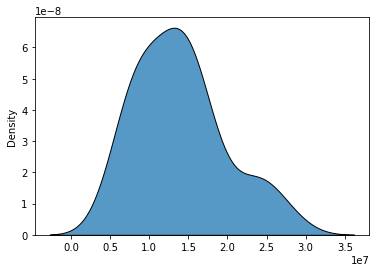

In [15]:
# Cross Validation Section
# Model 1
# Total Model 1
model_summary(X_one, y, alpha = 0, norm = "L2", R = 3, K = 10)

Model E{MSE}                      = 13331364.1512
Model variance                    = 34071.1321
Model [(bias)^2 + noise_variance] = 13297293.0191
 
Plot a kernel density estimate for MSE of this model below


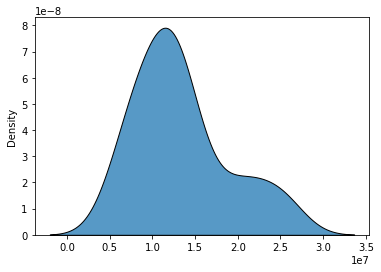

In [16]:
# Cross Validation Section
# Model 2
# Total Model 2
model_summary(X_two, y, alpha = 0, norm = "L2", R = 3, K = 10)

Model E{MSE}                      = 10787609.9029
Model variance                    = 37997.0926
Model [(bias)^2 + noise_variance] = 10749612.8103
 
Plot a kernel density estimate for MSE of this model below


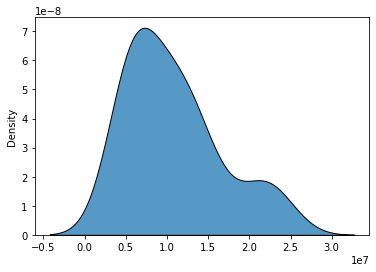

In [17]:
# Cross Validation Section
# Model 3
# Total Model 3
model_summary(X_three, y, alpha = 0, norm = "L2", R = 3, K = 10)

Model E{MSE}                      = 13932504.3158
Model variance                    = 17383.1476
Model [(bias)^2 + noise_variance] = 13915121.1682
 
Plot a kernel density estimate for MSE of this model below


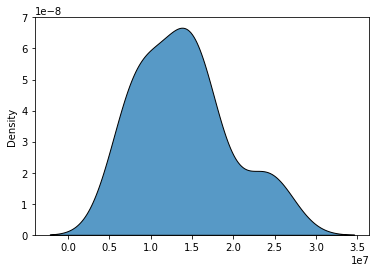

In [18]:
# Regularization Section
# Model 1
# Total model 4
model_summary(X_one, y, alpha = 10000, norm = "L2", R = 3, K = 10)

Model E{MSE}                      = 13345028.5078
Model variance                    = 29976.9704
Model [(bias)^2 + noise_variance] = 13315051.5374
 
Plot a kernel density estimate for MSE of this model below


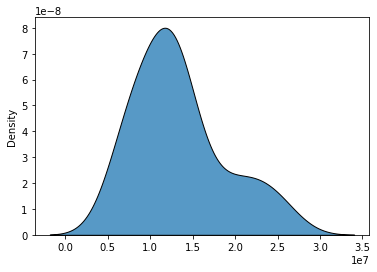

In [19]:
# Regularization Section
# Model 2
# Total Model 5
model_summary(X_two, y, alpha = 10000, norm = "L2", R = 3, K = 10)

Model E{MSE}                      = 11450997.9716
Model variance                    = 36076.6187
Model [(bias)^2 + noise_variance] = 11414921.3530
 
Plot a kernel density estimate for MSE of this model below


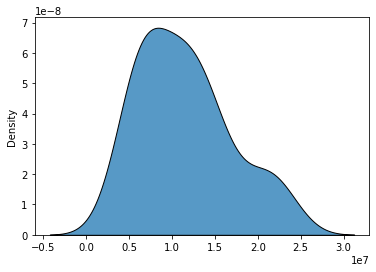

In [20]:
# Regularization Section
# Model 3
# Total Model 6
model_summary(X_three, y, alpha = 1, norm = "L2", R = 3, K = 10)

## Ending of Codes for Homework 2